# Mask R-CNN

In this lab, we're going to look at [Mask R-CNN](https://arxiv.org/abs/1703.06870). 

![Mask R-CNN from our video lectures](https://github.com/EmdaloTechnologies/CE6003/images/lab5/MaskRCNN.png?raw=1)

The implementation of Mask R-CNN we are going to use is one by [Matterport](https://matterport.com/), a company specialising in 3D capture.  Their implementation is based on TensorFlow 1.x using the Keras API, and is available on Github at https://github.com/matterport/Mask_RCNN

The model generates bounding boxes and segmentation masks for each instance of an object in the image. It's based on Feature Pyramid Network (FPN) and a ResNet101 as its base classifier. As it is quite a large network, it is not feasible for us to train Mask-RCNN within the Colab environment - so our usage here is restricted to demonstrating its powerful inference capabilities.  However, the GitHub link above does include information on downloading and training Mask R-CNN, including a Jupyter Notebook tutorial on training.

![Mask R-CNN Examples](https://github.com/EmdaloTechnologies/CE6003/images/lab5/MaskRCNN_examples.png?raw=1)


First, we'll import TensorFlow 1.x.

In [1]:
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras


*To* ensure these labs run as fast as possible, from the menu above select **Edit > Notebook settings or Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

**If** this outputs '', then we are running on CPU only. If it outputs something like '/device:GPU:0' then we are running on GPU. If you see something like ...

    Failed to assign a backend
    No backend with GPU available. WOuld you like to use a runtime with no accelerator?

This suggests that many other users have all the GPU resources on colab occupied at the moment, so perhaps try later or try using with the TPU instead.


Now, we'll continue to import the other Python libraries we need for this demo.

In [0]:
import os
import sys

import skimage.io
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Matterport implementation of Mask R-CNN

We'll clone the Mask R-CNN code directly from the Matterport GitHub repository. If we have run this step already, you'll see an error of the form `fatal: destination path 'Mask_RCNN' already exists and is not an empty directory` which you can safely ignore.

In [4]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config - this is use to configure our model later on
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

Using TensorFlow backend.


# Pre-trained weights - "Here's one we made earlier..."

We can leverage the fact that the model was already pre-trained using the Microsoft COCO dataset, and skip training here.

COCO, or Common Objects in Context, is a wonderful densely labelled large dataset for object detection, segmentation, and captioning. 


![COCO Examples](http://cocodataset.org/images/coco-examples.jpg)



COCO has several features:

* Object segmentation;
* Recognition in context;
* Superpixel stuff segmentation;
* 330K images (>200K labeled);
* 1.5 million object instances;
* 80 object categories;
* 91 stuff categories;
* 5 captions per imag
* 250,000 people with keypoints.

You can read more about COCO at http://cocodataset.org/#home

HDF5 (.h5, .hdf5) is a file format suitable for storing large multidimensional numeric arrays (e.g. models, data files). HDF stands for Hierarchical Data Format, and can store everything about your model, including:

* The architecture of the model;
* The weights of the model;
* The training configuration (loss, optimizer);
* The state of the optimizer, so you can resume training exactly where you left off.

You can read more about the HDF5 file format at http://docs.h5py.org/en/stable/quick.html, and at the Keras API for loading and saving models at https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model



In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


We'll create a list of class names for COCO, that we can use later in the lab. We have 81 separate classes, and so 81 separate names.

In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
len(class_names)

81

Let's take a look at the size of our downloaded weights file:

In [8]:
!ls -lh /content/Mask_RCNN/mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Nov 30 21:19 /content/Mask_RCNN/mask_rcnn_coco.h5


That's quite a lot of weight parameters when you think about it!  

We need to set our batch size to 1 for inference, so we'll subclass the config structure used in the Mask-RCNN code as follows, and we'll output the configuration - which will help us understand what type of network we're dealing with...

In [9]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Okay, we can see our base network ("BACKBONE") is *resnet101*, a 101-layer ResNet model. We have a mask shape ("MASK_SHAPE") of 28x28 pixels. We have a learning rate of 0.001 and a learning momentum of 0.9.

Our model has been trained with 81 classes ("NUM_CLASSES"), and we can see that we conveniently setup an array of class names earlier...

In [10]:
len(class_names)

81


# Model Creation, and Loading Weights

Now we need to create our model (using the Mask R-CNN code API) and then load the pre-trained weights into our model.

The Matterport code uses Keras, but the Keras version on Colab warns about some deprecated functions in TensorFlow 1.x that are changing name in TensorFlow 2.x.  As we don't care about this, we'll disable most of these warnings. You may still see some of the form `WARNING: ... is deprecated and will be removed in a future version` but you can safely ignore these.

In [11]:
# Disable warnings about deprecated TF 1.x functions vis-a-vis TF 2.x API
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0


# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.


Let's take a quick peek at our model. It is hidden as a `keras_model` variable within our mrcnn `model`:

In [12]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

64 million parameters, compared to ~100K for our MNIST ANN.  So it is quite a large network. However, VGG19, which was a popular *base* classifier, is approximately 140 million parameters, so the state of the art has improved (amongst other ideas, through the use ResNet and skip connections) in reducing the size of our deep nets at the same time as improving their performance and capabilities.

# Performing Inference

At this stage, we can take any random image and pass it through our model for inference.

You can execute the following cell as many times as you like, and it will pull a random image from the images folder, and perform inference on it, displaying the output.

Looking at ['1045023827_4ec3e8ba5c_z.jpg', '8699757338_c3941051b6_z.jpg', '9118579087_f9ffa19e63_z.jpg', '3651581213_f81963d1dd_z.jpg', '6821351586_59aa0dc110_z.jpg', '2516944023_d00345997d_z.jpg', '3878153025_8fde829928_z.jpg', '8512296263_5fc5458e20_z.jpg', '5951960966_d4e1cda5d0_z.jpg', '8053677163_d4c8f416be_z.jpg', '7933423348_c30bd9bd4e_z.jpg', '3862500489_6fd195d183_z.jpg', '8734543718_37f6b8bd45_z.jpg', '3627527276_6fe8cd9bfe_z.jpg', '6584515005_fce9cec486_z.jpg', '8433365521_9252889f9a_z.jpg', '12283150_12d37e6389_z.jpg', '4410436637_7b0ca36ee7_z.jpg', '262985539_1709e54576_z.jpg', '7581246086_cf7bbb7255_z.jpg', '3132016470_c27baa00e8_z.jpg', '4782628554_668bc31826_z.jpg', '25691390_f9944f61b5_z.jpg', '9247489789_132c0d534a_z.jpg', '8239308689_efa6c11b08_z.jpg', '2383514521_1fc8d7b0de_z.jpg', '3800883468_12af3c0b50_z.jpg', '8829708882_48f263491e_z.jpg', '2502287818_41e4b0c4fb_z.jpg']
Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max

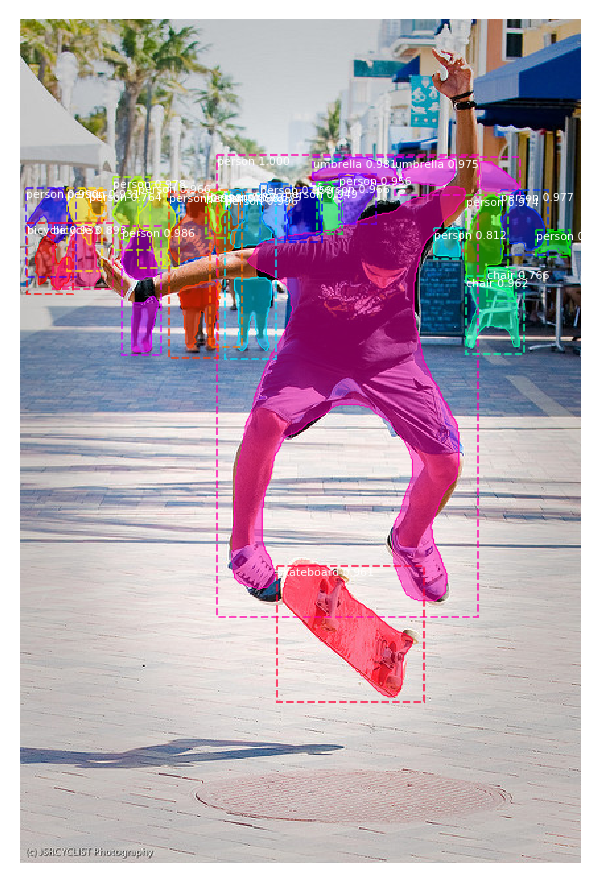

In [13]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
print("Looking at %s" % (file_names))
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

## Examing the results in more detail

The results dictionary, `r` is interesting. We can see it has a number of items in it, idenfified the by the keys `rois`, `class_ids`, `scores`, and `masks`.

In [14]:
r.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

We can easily see how many objects we identified and what they were...

In [15]:
numObjects = r['class_ids'].shape[0]

print("We identified %d objects:\n" % numObjects, end=" ")

count = 0
for class_id in r['class_ids']:
  if (count == 10):
    print("\n", end = " ")
    count = 0
  else:
    count += 1 
  print("%s" % class_names[class_id], end = " ")

We identified 27 objects:
 person person person person person umbrella person person umbrella person 
 person person chair skateboard person person person bicycle person person bicycle 
 person person person chair person person 

Thr rois key is used to get the *region of interest* bounding boxes.

In [16]:
r['rois']

array([[102, 149, 453, 347],
       [130, 113, 256, 150],
       [132, 155, 257, 194],
       [127,   4, 195,  42],
       [156,  77, 254, 107],
       [104, 222, 124, 290],
       [119,  70, 174,  98],
       [129, 365, 178, 400],
       [104, 284, 133, 379],
       [133, 338, 198, 370],
       [123, 225, 162, 244],
       [123,  89, 188, 120],
       [194, 338, 253, 382],
       [414, 195, 517, 306],
       [117, 242, 155, 270],
       [124, 182, 168, 205],
       [127, 201, 168, 229],
       [154,   5, 208,  40],
       [127,  35, 190,  62],
       [129, 144, 248, 168],
       [154,  25, 204,  70],
       [129, 158, 159, 172],
       [130, 141, 165, 158],
       [158, 314, 181, 336],
       [188, 354, 213, 376],
       [129,  52, 150,  65],
       [159, 391, 180, 417]], dtype=int32)

The bounding box format is `[topLeft_x, topLeft_y, bottomRight_x, bottomRight_y]`.

Now, let's take a look at the masks item in more detail.

Our mask shape (x_width, y_height, num_classes) is  (640, 425, 27)  - it has the same width and height as the input image.
Let's plot mask 0...


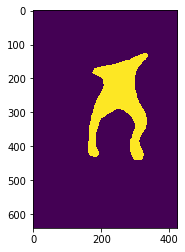

In [17]:
mask = r['masks']
mask = mask.astype(int)
print("Our mask shape (x_width, y_height, num_classes) is ", mask.shape, " - it has the same width and height as the input image.")
print("Let's plot mask 0...")
plt.imshow(mask[:,:,0])


Let's plot again, this time restricting to just the bounding box (102, 149, 453, 347)...


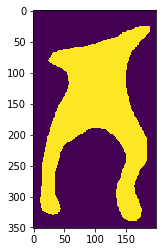

In [18]:

(tl_x, tl_y, br_x, br_y) = r['rois'][0]
print("\nLet's plot again, this time restricting to just the bounding box (%d, %d, %d, %d)..." % (tl_x, tl_y, br_x, br_y))

plt.imshow(mask[tl_x:br_x, tl_y:br_y, 0])

Masks is the same size as our input image, but note the number of channels (the third parameter above) -- this corresponds to the number of objects we detected.  In our masks, we have arrays of 0s and 1s which delineate the shape of each object.

The following cell will allow you to iterate through the shapes and example each one - set i to the index you want to look at...

There are 27 shapes in this image, we're going to look at shape 0.
Shape 0 is class_id 1, which has the label "person"



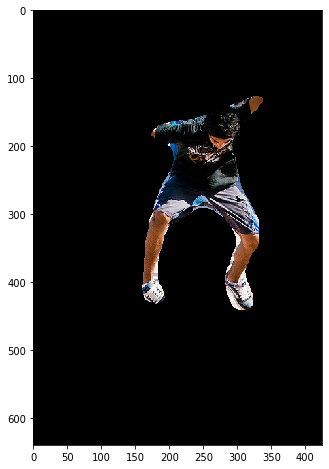

In [19]:
i = 0; # set i to the individual shape you want to look at...

class_id = r['class_ids'][i]
print("There are %d shape%s in this image, we're going to look at shape %d." % (mask.shape[2], "s" if mask.shape[2] != 1 else "", i))
print("Shape %d is class_id %d, which has the label \"%s\"\n" % (i, class_id, class_names[class_id]))

temp = image.copy()
for j in range(temp.shape[2]):
  temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
plt.figure(figsize=(8,8))
plt.imshow(temp)


# Try an example image from a web URL

You can also set the following variable `image_url` to point to a URL, and run the following cell to perform Mask R-CNN instance segmentation on any image. By default, we'll look at this image from a musical event from the Irish World Academy of Music and Dance ![Social Singing Event](https://www.ul.ie/sites/default/files/user_media/Social%20Singing%20Event.jpg)

Processing 1 images
image                    shape: (578, 1023, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


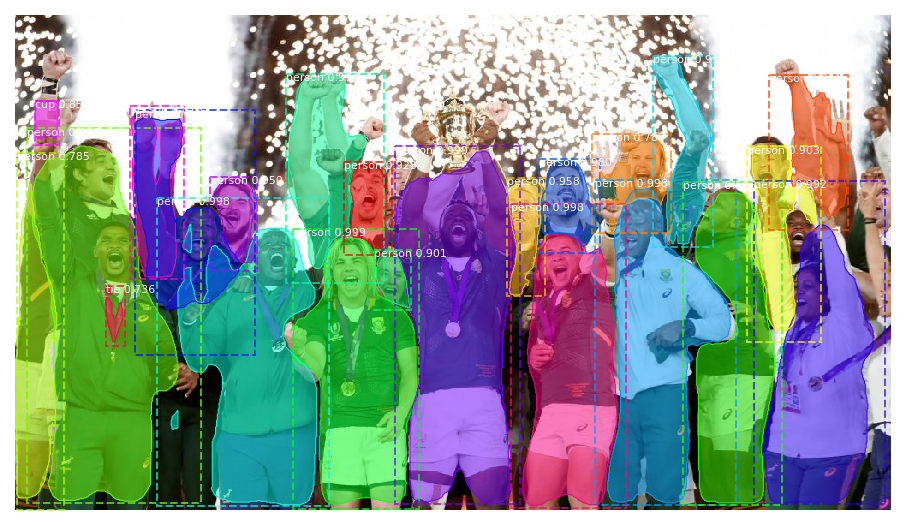

In [24]:
import numpy as np
import cv2
import urllib
 
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image

# read in test image
#image_url = "https://www.ul.ie/sites/default/files/user_media/Social%20Singing%20Event.jpg"
image_url = "http://scd.en.rfi.fr/sites/english.filesrfi/dynimagecache/0/270/3000/1695/1024/578/sites/images.rfi.fr/files/aefimagesnew/aef_image/2019-11-02t000000z_2096298590_up1efb20wzurx_rtrmadp_3_rugby-union-worldcup-eng-zaf.jpg"
image = url_to_image(image_url)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])